x_train.shape: (60000, 784)
y_train.shape: (60000, 10)
x_test.shape: (10000, 784)
y_test.shape: (10000, 10)
[epoch 10] loss = 2.29, accuracy = 0.47
[epoch 20] loss = 2.26, accuracy = 0.57
[epoch 30] loss = 2.20, accuracy = 0.58
[epoch 40] loss = 2.08, accuracy = 0.60
[epoch 50] loss = 1.87, accuracy = 0.64
[epoch 60] loss = 1.61, accuracy = 0.69
[epoch 70] loss = 1.34, accuracy = 0.72
[epoch 80] loss = 1.14, accuracy = 0.76
[epoch 90] loss = 0.98, accuracy = 0.79
[epoch 100] loss = 0.87, accuracy = 0.80
[epoch 110] loss = 0.78, accuracy = 0.82
[epoch 120] loss = 0.72, accuracy = 0.83
[epoch 130] loss = 0.67, accuracy = 0.84
[epoch 140] loss = 0.63, accuracy = 0.84
[epoch 150] loss = 0.59, accuracy = 0.85
[epoch 160] loss = 0.57, accuracy = 0.86
[epoch 170] loss = 0.54, accuracy = 0.86
[epoch 180] loss = 0.52, accuracy = 0.87
[epoch 190] loss = 0.50, accuracy = 0.87
[epoch 200] loss = 0.49, accuracy = 0.87
[epoch 210] loss = 0.47, accuracy = 0.88
[epoch 220] loss = 0.46, accuracy = 0.88

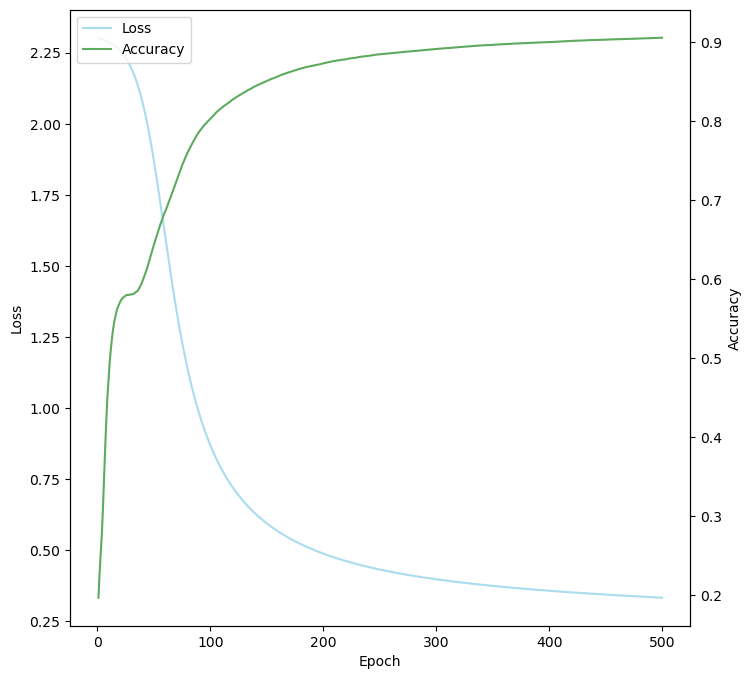

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow

def load_and_preprocess_data():
    # 加载MNIST数据集
    (x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.mnist.load_data()

    # 将二维图像展平为一维图像：np.ndarray([N_train/N_test, H, W]) -> np.ndarray([N_train/N_test, HW])
    x_train_flatten = x_train.reshape(-1, x_train.shape[1] * x_train.shape[2])
    x_test_flatten = x_test.reshape(-1, x_test.shape[1] * x_test.shape[2])
    
    # 归一化
    x_train_normalized = x_train_flatten / 255.0
    x_test_normalized = x_test_flatten / 255.0
    # 每个像素的值属于{0, 1, 2, ..., 255}，除以255后，每个像素的值位于[0, 1]区间

    # 将标签值转化为独热编码
    y_train_one_hot = one_hot(y_train, 10)
    y_test_one_hot = one_hot(y_test, 10)

    return x_train_normalized, y_train_one_hot, x_test_normalized, y_test_one_hot, y_train, y_test

def one_hot(y, class_num):
    y_one_hot = np.zeros([y.size, class_num])
    y_one_hot[[i for i in range(y.size)], y] = 1
    return y_one_hot

def initialize_parameters(input_size, hidden_size, output_size):
    # input_size -> 输入的特征维度
    # hidden -> 隐藏层的特征维度
    # output_size -> 输出的特征维度
    
    # 用标准正态分布（均值为0，方差为1）初始化参数；乘0.01后方差为1e-4
    w1 = np.random.randn(input_size, hidden_size) * 0.01
    b1 = np.zeros([1, hidden_size])
    w2 = np.random.randn(hidden_size, output_size) * 0.01
    b2 = np.zeros([1, output_size])
    return {'w1': w1, 'b1': b1, 'w2': w2, 'b2': b2}

def relu(z):
    # 隐藏层激活函数ReLU
    return np.maximum(0, z)

def relu_derivative(z):
    # ReLU函数的导数
    return z > 0 # 大于0的值为True(1)，小于0的值为False(0)

def softmax(z):
    # 输出层激活函数softmax
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True)) # 为防止数值溢出进行优化
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def forward_propagation(x, params):
    # 前向传播函数
    # x -> np.ndarray([N, HW])
    # params -> w1, b1, w2, b2
    
    w1 = params['w1']
    b1 = params['b1']
    w2 = params['w2']
    b2 = params['b2']

    z1 = np.dot(x, w1) + b1
    a1 = relu(z1)
    z2 = np.dot(a1, w2) + b2
    a2 = softmax(z2)

    cache = {'z1': z1, 'a1': a1, 'z2': z2, 'a2': a2}
    return cache

def compute_loss(a2, y):
    # 添加一个极小值1e-8防止log(0)
    return np.sum(-y * np.log(a2 + 1e-8)) / y.shape[0]

def backward_propagation(params, cache, x, y):
    # 反向传播，计算梯度
    w2 = params['w2']
    a1 = cache['a1']
    a2 = cache['a2']
    z1 = cache['z1']

    # 输出层梯度
    d_z2 = a2 - y
    
    # z2 = a1w2 + b2
    # 对w2、b2的梯度
    d_w2 = np.dot(a1.T, d_z2)
    d_b2 = np.sum(d_z2, axis=0, keepdims=False)
    d_a1 = np.dot(d_z2, w2.T)
    d_z1 = d_a1 * relu_derivative(z1)
    d_w1 = np.dot(x.T, d_z1)
    d_b1 = np.sum(d_z1, axis=0, keepdims=False)

    # 损失函数前面乘1/N，梯度也应当乘1/N
    d_w1 = d_w1 / x.shape[0]
    d_b1 = d_b1 / x.shape[0]
    d_w2 = d_w2 / x.shape[0]
    d_b2 = d_b2 / x.shape[0]
    
    return {'d_w1': d_w1, 'd_b1': d_b1, 'd_w2': d_w2, 'd_b2': d_b2}

def update_parameters(params, grads, learning_rate):
    # 更新参数
    
    params['w1'] = params['w1'] - learning_rate * grads['d_w1']
    params['b1'] = params['b1'] - learning_rate * grads['d_b1']
    params['w2'] = params['w2'] - learning_rate * grads['d_w2']
    params['b2'] = params['b2'] - learning_rate * grads['d_b2']

    return params

def main(reduction, num_epochs, learning_rate):
    # 加载数据集并预处理
    x_train, y_train, x_test, y_test, y_train_value, y_test_value = load_and_preprocess_data()

    print(f'x_train.shape: {x_train.shape}')
    print(f'y_train.shape: {y_train.shape}')
    print(f'x_test.shape: {x_test.shape}')
    print(f'y_test.shape: {y_test.shape}')

    # 初始化参数
    params = initialize_parameters(x_train.shape[1], x_train.shape[1] // reduction, y_train.shape[1])
    
    # history -> 记录每轮训练后的损失函数与预测准确率
    history = {'loss': [], 'accuracy': []}
    for epoch in range(num_epochs):
        cache = forward_propagation(x_train, params)
        grads = backward_propagation(params, cache, x_train, y_train)
        params = update_parameters(params, grads, learning_rate)

        loss = compute_loss(cache['a2'], y_train)
        pred = forward_propagation(x_train, params)['a2']
        accuracy = np.sum(np.argmax(pred, axis=1, keepdims=False) == y_train_value) / y_train_value.size
        if (epoch + 1) % 10 == 0:
            print(f'[epoch {epoch + 1}] loss = {loss:.2f}, accuracy = {accuracy:.2f}')
        history['loss'].append(loss)
        history['accuracy'].append(accuracy)

    # 在测试集上评估
    pred_test = forward_propagation(x_test, params)['a2']
    accuracy_test = np.sum(np.argmax(pred_test, axis=1, keepdims=False) == y_test_value) / y_test_value.size

    print(f'\n测试集上的准确率为：{accuracy_test}')

    plt.figure(figsize=(8, 8))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    line1 = plt.plot([i for i in range(1, num_epochs + 1)], history['loss'], label='Loss', color='#AADCF0')[0]
    plt.twinx()
    plt.ylabel('Accuracy')
    line2 = plt.plot([i for i in range(1, num_epochs + 1)], history['accuracy'], label='Accuracy', color='#5EAA5E')[0]
    lines = [line1, line2]
    labels = [line1.get_label(), line2.get_label()]
    plt.legend(lines, labels)
    plt.show()

if __name__ == '__main__':
    main(4, 500, 0.1)